## Which minima are preferred by which optimizers?
#### Project for OptML course at EPFL

When training a neural net, the resulting stationary point $\nabla f(x)=0$ depends on many things like initialization, optimization algorithm, batch size, learning rate and others. It was hypothesized in 1997 [1] that not all minima of a neural network are the same when it comes to generalization capabilities. In particular it was conjectured that the more a minimum is *flat*, meaning that Hessian $\frac{\partial f}{\partial \theta^2}$ eigenvalues are small, the better network generalizes. The reasoning is that a more flat minimum means that parameter perturbation would not change (spoil) the loss a lot.

The problem with this approach was pointed out in [2]. It was shown that a fixed network can be reparametrized such that it has arbitrary sharpness. Therefore the function represented is the same (and having same generalization capabilities) but sharpness would be different.

Current research focuses on trying to quantify sharpness in another form. For example, paper [4] visualizes the loss landscape in two random directions and proposes to normalize the weights. In [3] another idea is considered: cosine similarity between gradients on different batches is considered as a new generalization metric.

The paper [5] uses another normalized sharpness metric and shows that it correlates with generalization gap well. PAC-Bayesian approach tries to quantify the difference between test and train errors using KL divergence between these distributions. The paper uses a mix between Hessian diagonal values and weight matrix norms.

Paper [6] tackles the problem by estimating Hessian spectral density empirically using techniques allowing for computational feasibility for large networks.

Paper [7] proposes another scale-invariant generalization metric.

We note that the papers usually study the effect of different batch sizes on the generalization properties. In this project we compare the effect of **optimizer** on the sharpness metrics as well as on generalization properties.

We propose to use the following datsets for our experiment:
1. Fisher's Iris dataset (150 objects, 5 features, 3 classes)
2. Boston Housing dataset (~500 objects, 15 features, regression)
3. MNIST dataset (70000 objects, 28x28 features, 10 classes)

We will use the following [optimizers](https://keras.io/optimizers/):
1. (S)GD
2. SGD with momentum
3. AdaDelta

And will vary the following parameters:
1. Batch size
2. Learning rate
3. [Initialization](https://keras.io/initializers/) (Normal, Uniform, Orthogonal, LeCun, Glorot)

We plan to measure the following metrics:
1. Empirical generalization gap
2. Hessian spectrum
3. Proposed metric from [3]
4. Proposed metric from [4]
5. Proposed metric from [5]
6. Proposed metric from [7]

Our main contribution would be to **measure the effect of optimizer on minima quality**

[1] Hochreiter, Sepp and Schmidhuber, Jürgen. [Flat minima](http://www.bioinf.jku.at/publications/older/3304.pdf). Neural Computation, 9(1):1–42, 1997.

[2] Dinh, Laurent, et al. [Sharp minima can generalize for deep nets](https://arxiv.org/pdf/1703.04933.pdf). Proceedings of ICML-Volume 70. JMLR. org, 2017.

[3] [The Generalization Mystery: Sharp vs Flat Minima](https://www.inference.vc/sharp-vs-flat-minima-are-still-a-mystery-to-me/)

[4] Li H, Xu Z, Taylor G, Studer C, Goldstein T. [Visualizing the loss landscape of neural nets](https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf). In NeurIPS 2018 (pp. 6391-6401).

[5] Tsuzuku Y, Sato I, Sugiyama M. [Normalized Flat Minima: Exploring Scale Invariant Definition of Flat Minima for Neural Networks using PAC-Bayesian Analysis](https://arxiv.org/pdf/1901.04653.pdf). arXiv preprint arXiv:1901.04653. 2019 Jan 15.

[6] Ghorbani B, Krishnan S, Xiao Y. [An Investigation into Neural Net Optimization via Hessian Eigenvalue Density](https://arxiv.org/pdf/1901.10159.pdf). arXiv preprint arXiv:1901.10159. 2019 Jan 29.

[7] Rangamani A, Nguyen NH, Kumar A, Phan D, Chin SH, Tran TD. [A Scale Invariant Flatness Measure for Deep Network Minima](https://arxiv.org/pdf/1902.02434.pdf). arXiv preprint arXiv:1902.02434. 2019 Feb 6.

In [75]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
from helpers import *
import PIL
from PIL import Image
%load_ext autoreload
%autoreload 2
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

Using feedforward fully-connected neural network with input size 28^2, 5 layers (28^2-40-40-30-30-10-1), 10-dim output (classification). Using MNIST as data. Using optimizers: SGD, Adam. Plotting spectra of the hessian after convergence. Using 10 repetitions of the experiment.

60000it [00:04, 14907.65it/s]
10000it [00:00, 12297.81it/s]


(7, 7)


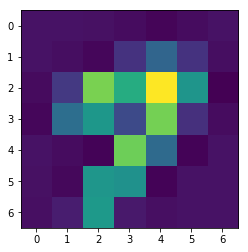

In [77]:
input_shape, output_shape, x_train, x_test, y_train, y_test = get_mnist(7)

plt.imshow(x_train[15])
print(input_shape)

In [78]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [79]:
# input data: batch w h channels
x = tf.placeholder(tf.float32, shape = (None, *input_shape), name = 'input')

# output labels (vector)
y = tf.placeholder(tf.int64, shape = (None,), name = 'labels')

# one-hot encoded labels
y_one_hot = tf.one_hot(y, output_shape)

In [80]:
# creating the model
model = FCModelConcat([np.prod(input_shape), 20, 20, output_shape], activation = tf.nn.sigmoid)

In [81]:
# model output
output = model.forward(x)

In [82]:
# flatten w * h
l0 = tf.contrib.layers.flatten(x)

# softmax to make probability distribution
logits = tf.nn.softmax(output)

# predicted labels
labels = tf.argmax(logits, axis = 1)

# loss: cross-entropy
loss = tf.losses.softmax_cross_entropy(y_one_hot, logits)

# accuracy of predictions
accuracy = tf.contrib.metrics.accuracy(labels, y)

In [83]:
# list of all parameters
params = tf.trainable_variables()#tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

In [84]:
# get the Hessian of the model
hessian = tf.hessians(loss, model.W)

In [85]:
K = np.sum([np.prod(p.shape).value for p in params])

In [86]:
print('Total parameters:', K)
print('Hessian size: %.2f MB' % (K * K / 1e6))

Total parameters: 1630
Hessian size: 2.66 MB


In [95]:
batch_size = 10000

100%|██████████| 100/100 [00:02<00:00, 42.05it/s]


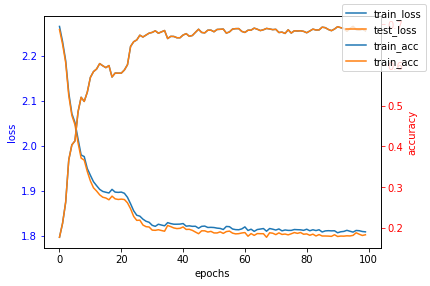

{'train_loss': [2.264779,
  2.2310503,
  2.1890254,
  2.1173642,
  2.071259,
  2.0517082,
  2.0153227,
  1.9794719,
  1.9759531,
  1.9492487,
  1.934369,
  1.9201127,
  1.9113905,
  1.9031565,
  1.898549,
  1.8967522,
  1.8951598,
  1.9031403,
  1.8970677,
  1.8964604,
  1.8971184,
  1.8944613,
  1.8854492,
  1.8711677,
  1.8556365,
  1.8457209,
  1.8436936,
  1.837038,
  1.8323789,
  1.8300878,
  1.8233486,
  1.8210734,
  1.8257865,
  1.8239334,
  1.82224,
  1.8292841,
  1.8272343,
  1.8257767,
  1.8258122,
  1.826058,
  1.8272626,
  1.8214359,
  1.8222471,
  1.8210814,
  1.8212552,
  1.8168726,
  1.8210638,
  1.8216394,
  1.8185735,
  1.8188612,
  1.818441,
  1.8171095,
  1.8164492,
  1.8140317,
  1.8208518,
  1.8203334,
  1.8151572,
  1.8137789,
  1.8135204,
  1.8154198,
  1.8198904,
  1.8118688,
  1.81476,
  1.8098866,
  1.8139894,
  1.815056,
  1.816186,
  1.8102106,
  1.8162726,
  1.8147664,
  1.8128406,
  1.8152845,
  1.8110704,
  1.8130127,
  1.8120916,
  1.8121003,
  1.8140273

In [96]:
train(gd, 100, sess, batch_size, loss, accuracy, x_train, y_train, x, y, x_test, y_test, '1')

In [99]:
sess.run(tf.norm(model.W, ord = 3))

9.8652935

In [88]:
#gd = OwnGradientDescent(gamma = 0.1, theta = 1).minimize(loss)
gd = tf.train.AdamOptimizer(0.01).minimize(loss)
#gd = StochasticFrankWolfe(R = 100, p = 2, gamma = 0.01, ro = 0.6).minimize(loss)

100%|██████████| 300/300 [00:07<00:00, 42.29it/s]


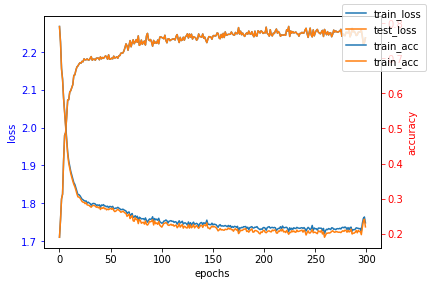

  2%|▏         | 5/300 [00:00<00:07, 41.11it/s]

Done: 1/20/1


100%|██████████| 300/300 [00:08<00:00, 36.06it/s]


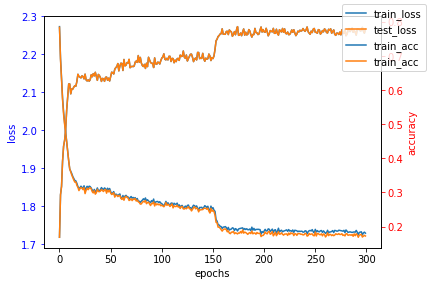

  2%|▏         | 5/300 [00:00<00:06, 44.85it/s]

Done: 2/20/2


100%|██████████| 300/300 [00:07<00:00, 35.38it/s]


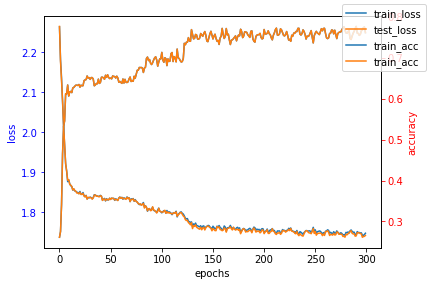

  2%|▏         | 5/300 [00:00<00:07, 40.54it/s]

Done: 3/20/3


100%|██████████| 300/300 [00:07<00:00, 42.24it/s]


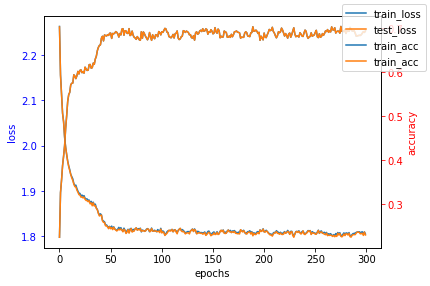

  2%|▏         | 5/300 [00:00<00:06, 42.35it/s]

Done: 4/20/4


100%|██████████| 300/300 [00:07<00:00, 40.50it/s]


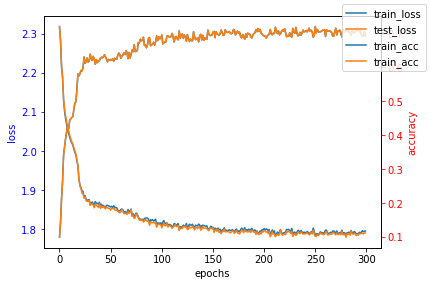

  2%|▏         | 5/300 [00:00<00:07, 41.15it/s]

Done: 5/20/5


100%|██████████| 300/300 [00:06<00:00, 43.82it/s]


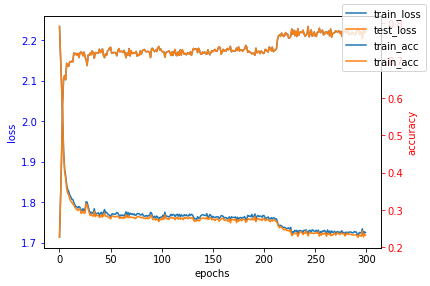

  2%|▏         | 5/300 [00:00<00:07, 41.28it/s]

Done: 6/20/6


100%|██████████| 300/300 [00:07<00:00, 41.94it/s]


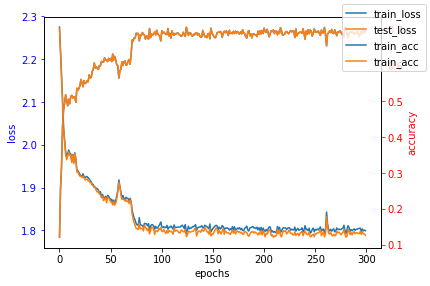

  2%|▏         | 5/300 [00:00<00:07, 41.41it/s]

Done: 7/20/7


100%|██████████| 300/300 [00:07<00:00, 40.15it/s]


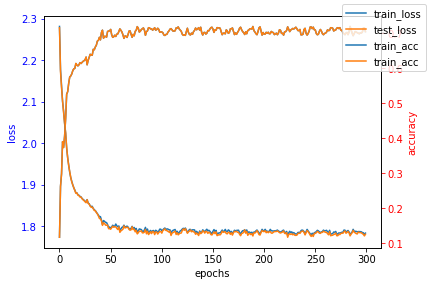

  2%|▏         | 5/300 [00:00<00:07, 41.26it/s]

Done: 8/20/8


100%|██████████| 300/300 [00:06<00:00, 43.71it/s]


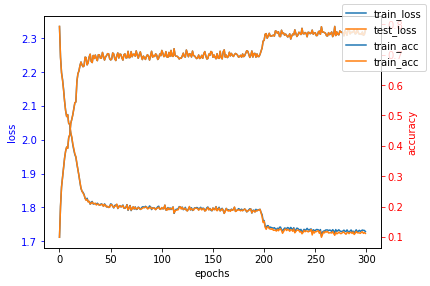

  1%|          | 3/300 [00:00<00:09, 29.84it/s]

Done: 9/20/9


100%|██████████| 300/300 [00:06<00:00, 43.45it/s]


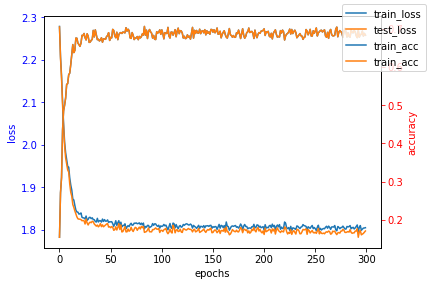

  2%|▏         | 5/300 [00:00<00:07, 40.96it/s]

Done: 10/20/10


100%|██████████| 300/300 [00:07<00:00, 42.81it/s]


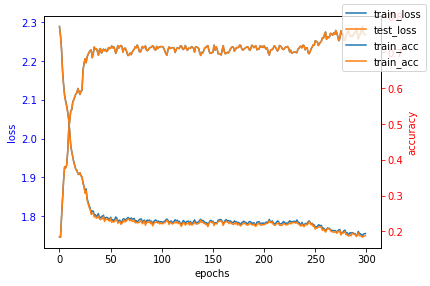

  2%|▏         | 5/300 [00:00<00:06, 42.58it/s]

Done: 11/20/11


100%|██████████| 300/300 [00:07<00:00, 41.52it/s]


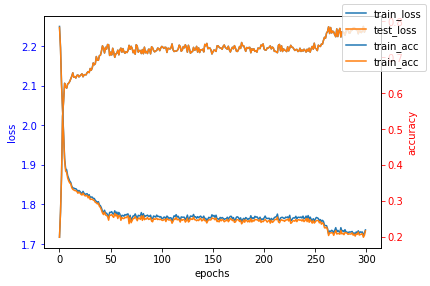

  2%|▏         | 5/300 [00:00<00:07, 41.08it/s]

Done: 12/20/12


100%|██████████| 300/300 [00:06<00:00, 43.39it/s]


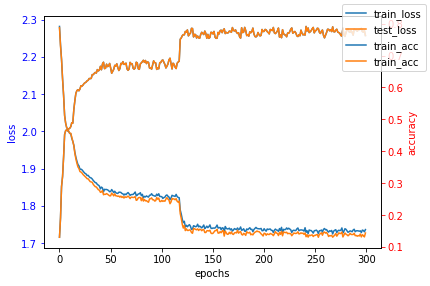

  1%|▏         | 4/300 [00:00<00:07, 39.98it/s]

Done: 13/20/13


100%|██████████| 300/300 [00:06<00:00, 43.78it/s]


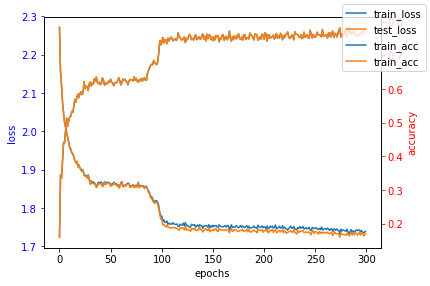

  2%|▏         | 5/300 [00:00<00:07, 40.41it/s]

Done: 14/20/14


100%|██████████| 300/300 [00:07<00:00, 38.63it/s]


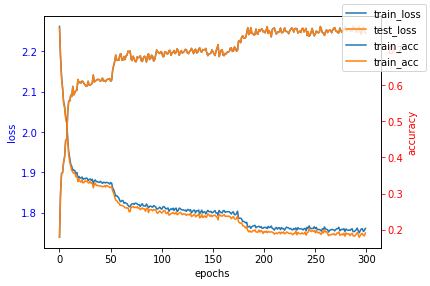

  1%|▏         | 4/300 [00:00<00:08, 36.03it/s]

Done: 15/20/15


100%|██████████| 300/300 [00:06<00:00, 43.66it/s]


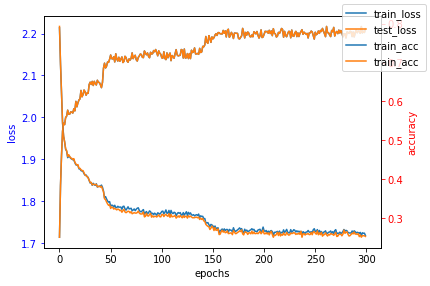

  1%|▏         | 4/300 [00:00<00:08, 33.43it/s]

Done: 16/20/16


100%|██████████| 300/300 [00:06<00:00, 43.70it/s]


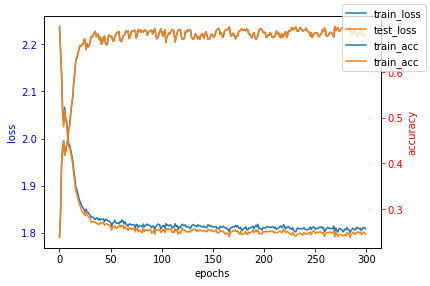

  2%|▏         | 5/300 [00:00<00:07, 41.00it/s]

Done: 17/20/17


100%|██████████| 300/300 [00:08<00:00, 36.99it/s]


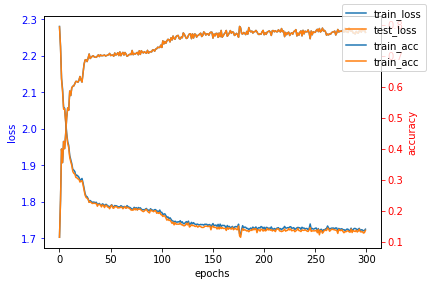

  2%|▏         | 5/300 [00:00<00:07, 40.96it/s]

Done: 18/20/18


100%|██████████| 300/300 [00:07<00:00, 44.24it/s]


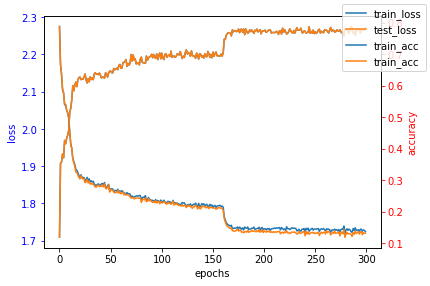

  2%|▏         | 5/300 [00:00<00:07, 40.45it/s]

Done: 19/20/19


100%|██████████| 300/300 [00:08<00:00, 36.32it/s]


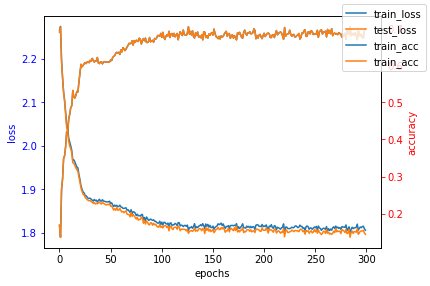

Done: 20/20/20


NameError: name 'result' is not defined

In [74]:
results = experiment_for_optimizer(gd, epochs = 300, accuracy_threshold = 0, repetitions = 1,
                         giveup = 10, sess = sess, x_train = x_train, y_train = y_train, x = x, y = y,
                         hessian = hessian, accuracy = accuracy, loss = loss, batch_size = 10000,
                        x_test = x_test, y_test = y_test, name = 'adam')

## Experiments for Adam and GD, measuring spectrum of Hessian

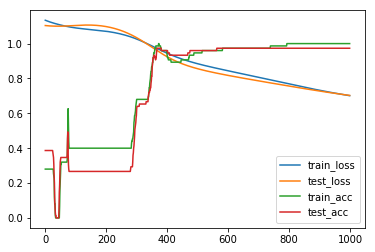

Done: 20/20


In [19]:
adam = tf.train.AdamOptimizer().minimize(loss)
eig_adam = experiment_for_optimizer(adam, epochs = 1000, accuracy_threshold = 0.9, repetitions = 20)

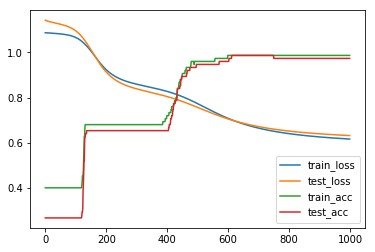

Done: 20/20


In [24]:
gd = OwnGradientDescent(gamma = 0.5, theta = 0.999).minimize(loss, params)
eig_gd = experiment_for_optimizer(gd, epochs = 1000, accuracy_threshold = 0.9, repetitions = 20)

In [25]:
def hist_th(eigens, threshold = 100, name = 'GD'):
    plt.hist(np.extract(np.abs(eigens) < threshold, np.abs(eigens)), label = name, alpha = 0.5)
    #plt.show()

In [26]:
def plot_for_thr(threshold = 100):
    plt.figure()
    hist_th(eig_gd, threshold, 'GD')
    hist_th(eig_adam, threshold, 'Adam')
    plt.legend()

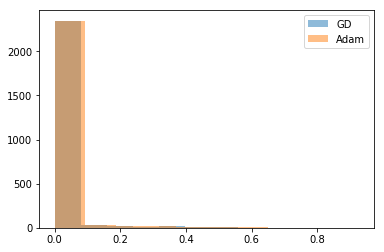

In [27]:
plot_for_thr(1)

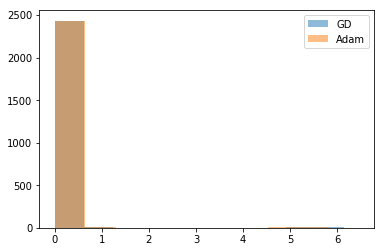

In [28]:
plot_for_thr(100)

Spectra are similar close to $0$, GD has a bit larger maximal eigenvalues.

### Gradient descent with different learning rates

In [29]:
learning_rates = np.linspace(0.2, 0.6, 5)

In [30]:
def experiment_for_rate(rate, epochs = 1000, theta = 0.999):
    """ Train repetitions copies of a network with GD(rate), output
    Hessian eigenvalues of those satisfying accuracy threshold"""
    
    gd = OwnGradientDescent(gamma = rate, theta = theta).minimize(loss, params)
    return experiment_for_optimizer(gd, epochs = epochs)

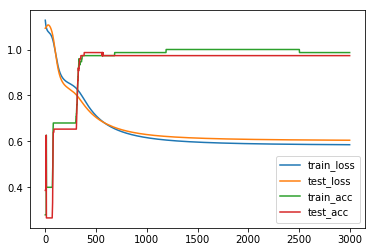

Done: 20/20


In [31]:
eigens_for_rate = {rate: experiment_for_rate(rate, epochs = 3000) for rate in learning_rates}

1.4262876e-06 0.2
1.2696701e-06 0.3
7.7104437e-07 0.4
1.1779134e-06 0.5
9.34483e-07 0.6


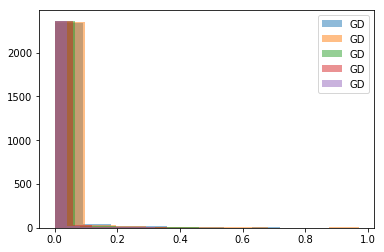

In [32]:
for r in learning_rates:
    print(np.median(eigens_for_rate[r]), r)
    hist_th(eigens_for_rate[r], threshold = 1, name = 'GD')
    plt.legend()
    #plt.show()

Bigger learning rate results in smaller eigenvalues (more sharp minima)?